In [1]:
import wandb
import datetime
import argparse
import numpy as np
from train_and_test import train_and_test
from helpers import get_NWP_data, get_rain_gauge_or_radar_data, sw_func, find_experiment_directory, make_name_string
from evaluator import only_MSE_and_GSS
import sys
from tensorflow import device

from models.model import model

# Fixed paramters
project = "Thesis Experiment 2 and 3"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "RVK-BOD": [0, 15,  30,  45,  60,  75,  90,  105, 120, 135, 150],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }

evaluation_config = {
    'eval_forecast_start': 24,
    'eval_forecast_end':30,
}


parser = argparse.ArgumentParser()
parser.add_argument("-r","--regularization",type=float,default=0.1,metavar="regularization",)
parser.add_argument("-u","--units",type=float,default=0,metavar="units",)
parser.add_argument("-f","--filters",type=float,default=0,metavar="filters",)
parser.add_argument("-l","--lr",type=float,default=0.1,metavar="lr",)
parser.add_argument("-w","--weights",type=str,default='a',metavar="lr",)
parser.add_argument("-b","--batch_size",type=int,default=256,metavar="batch_size",)
parser.add_argument("-d","--data_source",type=str,default='gauge',metavar="data_source",)
parser.add_argument("-o","--obs",type=int,default='3',metavar="obs",)

    

_StoreAction(option_strings=['-o', '--obs'], dest='obs', nargs=None, const=None, default='3', type=<class 'int'>, choices=None, help=None, metavar='obs')

In [2]:
args = parser.parse_args([
                "--regularization",  "0",
                "--units",           "0",
                "--filters",         "0",
                "--lr",              "0.1",
                "--batch_size",      "254",
                "--data_source",     "NWP",
                "--obs",             "20",
            ])

In [11]:
import pandas as pd
from collections import defaultdict

def use_old_forecasts_as_observations(X, NWP_dates, n_obs):
    NWP_dates = np.array(NWP_dates)
    start_date = NWP_dates[0]
    end_date = NWP_dates[-1]
    dates = pd.date_range(start_date,end_date,freq='6h')
    df_forecasts = pd.DataFrame(index=dates,columns = range((1-n_obs),61))
    for col in df_forecasts.columns:
        if col > 0:
            df_forecasts.loc[NWP_dates,col] = [(index,col) for index in NWP_dates]
            
    # The age of the forecast being used to fill in old observations
    # if it's desireable to use older forecasts due to something like
    # convergence of the forecasted rainfall, then this is the parameter
    forecast_age = 1
    for i in range(np.ceil(n_obs / 6).astype(int)):
        i_start = 1-6*(i+1)
        i_end = -6*i
        row_shift = (i+forecast_age)
        col_shift = -(i+forecast_age)*6
        df_forecasts.loc[:,i_start:i_end] = df_forecasts.shift(row_shift,axis=0).shift(col_shift,axis=1).loc[:,i_start:i_end]
        

    date_to_index = defaultdict(lambda : [])
    date_to_index.update({date:index for index,date in enumerate(NWP_dates)})
    old_forecasts = np.zeros((X.shape[0],n_obs,X.shape[2]))
    X_with_obs = np.concatenate([old_forecasts,X],axis=1)

    for to_col in range(n_obs):
        for to_date,fro in df_forecasts.iloc[:,to_col].iteritems():
            if type(fro) == type(np.nan):
                continue
            (from_date,from_column) = fro
            from_row = date_to_index[from_date]
            from_col = from_column - 1
            to_row = date_to_index[to_date]
            X_with_obs[to_row,to_col] = X_with_obs[from_row,from_col+n_obs]
            
    return X_with_obs

In [24]:

config_model = {
    'regularization':args.regularization,
    'units':args.units,
    'filters':args.filters,
    
    'lr': args.lr,
    'batch_size': args.batch_size,
    'data_source': args.data_source,
    'obs': args.obs,
}
    
# Get data
if args.data_source == "NWP":
    X1, X2, X3, Y = get_NWP_data(threshold_dict,temperature_name,config_model['obs'],pred_dist,d_start,d_end)
    NWP_dates = get_NWP_data(threshold_dict,temperature_name,config_model['obs'],pred_dist,d_start,d_end,return_just_dates=True)
    n,f,*_ = X1.shape
    X1 = X1.reshape((n,f,-1))
    X2 = X2.reshape((n,f,-1))
    X3 = X3.reshape((n,f,-1))
    X_before_obs = np.concatenate([X1,X2,X3],axis=-1)
    
    n,f,p = X_before_obs.shape
    X_after_obs = use_old_forecasts_as_observations(X_before_obs, NWP_dates, config_model['obs']-1)
    X = np.lib.stride_tricks.sliding_window_view(X_after_obs, (1,config_model['obs'],p)).reshape(-1,config_model['obs'],p)
    Y = Y.reshape(-1,2)
    # Transform such that the shape is (n*f,obs,-1)
    # and for 'observations' of rainfall, we instead use old forecasts
    
    

elif args.data_source == "radar":
    X1,_,X2,X3,Y = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,config_model['obs'],d_start,d_end)
    X = np.concatenate([X1, X2, X3],axis=-1)
elif args.data_source == "gauge":
    _,X1,X2,X3,Y = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,config_model['obs'],d_start,d_end)
    X = np.concatenate([X1, X2, X3],axis=-1)
    

In [23]:
Y.reshape(-1,2).shape,X.shape

((297120, 2), (297120, 20, 125))

In [334]:
# offset = 80
# plt.plot(X_after_obs[offset + 10,:20,0])
# plt.plot(X_after_obs[offset + 9,6:26,0] + 1)
# plt.plot(X_after_obs[offset + 8,12:32,0] + 2)
X_after_obs

In [326]:
# plt.plot(X_with_obs.sum(axis=(0,2)))

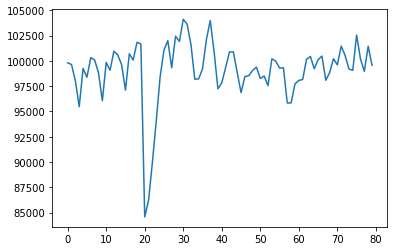

In [332]:
plt.plot(X_with_obs.sum(axis=(0,2)))

In [265]:
('2015-11-01 00:00:00', 1)
tmp_date,tmp_col = df_forecasts.iat[2800,2]
row = date_to_index[tmp_date]
col = tmp_col - 1

In [245]:
df_forecasts.loc[NWP_dates,-config_model['obs']:0]

,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
2015-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(2015-11-01 00:00:00, 1)","(2015-11-01 00:00:00, 2)","(2015-11-01 00:00:00, 3)","(2015-11-01 00:00:00, 4)","(2015-11-01 00:00:00, 5)","(2015-11-01 00:00:00, 6)"
2015-11-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(2015-11-01 00:00:00, 1)","(2015-11-01 00:00:00, 2)","(2015-11-01 00:00:00, 3)","(2015-11-01 00:00:00, 4)","(2015-11-01 00:00:00, 5)","(2015-11-01 00:00:00, 6)","(2015-11-01 06:00:00, 1)","(2015-11-01 06:00:00, 2)","(2015-11-01 06:00:00, 3)","(2015-11-01 06:00:00, 4)","(2015-11-01 06:00:00, 5)","(2015-11-01 06:00:00, 6)"
2015-11-01 18:00:00,NaN,NaN,"(2015-11-01 00:00:00, 1)","(2015-11-01 00:00:00, 2)","(2015-11-01 00:00:00, 3)","(2015-11-01 00:00:00, 4)","(2015-11-01 00:00:00, 5)","(2015-11-01 00:00:00, 6)","(2015-11-01 06:00:00, 1)","(2015-11-01 06:00:00, 2)","(2015-11-01 06:00:00, 3)","(2015-11-01 06:00:00, 4)","(2015-11-01 06:00:00, 5)","(2015-11-01 06:00:00, 6)","(2015-11-01 12:00:00, 1)","(2015-11-01 12:00:00, 2)","(2015-11-01 12:00:00, 3)","(2015-11-01 12:00:00, 4)","(2015-11-01 12:00:00, 5)","(2015-11-01 12:00:00, 6)"
2015-11-02 00:00:00,"(2015-11-01 00:00:00, 5)","(2015-11-01 00:00:00, 6)","(2015-11-01 06:00:00, 1)","(2015-11-01 06:00:00, 2)","(2015-11-01 06:00:00, 3)","(2015-11-01 06:00:00, 4)","(2015-11-01 06:00:00, 5)","(2015-11-01 06:00:00, 6)","(2015-11-01 12:00:00, 1)","(2015-11-01 12:00:00, 2)","(2015-11-01 12:00:00, 3)","(2015-11-01 12:00:00, 4)","(2015-11-01 12:00:00, 5)","(2015-11-01 12:00:00, 6)","(2015-11-01 18:00:00, 1)","(2015-11-01 18:00:00, 2)","(2015-11-01 18:00:00, 3)","(2015-11-01 18:00:00, 4)","(2015-11-01 18:00:00, 5)","(2015-11-01 18:00:00, 6)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28 06:00:00,"(2019-12-27 06:00:00, 5)","(2019-12-27 06:00:00, 6)","(2019-12-27 12:00:00, 1)","(2019-12-27 12:00:00, 2)","(2019-12-27 12:00:00, 3)","(2019-12-27 12:00:00, 4)","(2019-12-27 12:00:00, 5)","(2019-12-27 12:00:00, 6)","(2019-12-27 18:00:00, 1)","(2019-12-27 18:00:00, 2)","(2019-12-27 18:00:00, 3)","(2019-12-27 18:00:00, 4)","(2019-12-27 18:00:00, 5)","(2019-12-27 18:00:00, 6)","(2019-12-28 00:00:00, 1)","(2019-12-28 00:00:00, 2)","(2019-12-28 00:00:00, 3)","(2019-12-28 00:00:00, 4)","(2019-12-28 00:00:00, 5)","(2019-12-28 00:00:00, 6)"
2019-12-28 12:00:00,"(2019-12-27 12:00:00, 5)","(2019-12-27 12:00:00, 6)","(2019-12-27 18:00:00, 1)","(2019-12-27 18:00:00, 2)","(2019-12-27 18:00:00, 3)","(2019-12-27 18:00:00, 4)","(2019-12-27 18:00:00, 5)","(2019-12-27 18:00:00, 6)","(2019-12-28 00:00:00, 1)","(2019-12-28 00:00:00, 2)","(2019-12-28 00:00:00, 3)","(2019-12-28 00:00:00, 4)","(2019-12-28 00:00:00, 5)","(2019-12-28 00:00:00, 6)","(2019-12-28 06:00:00, 1)","(2019-12-28 06:00:00, 2)","(2019-12-28 06:00:00, 3)","(2019-12-28 06:00:00, 4)","(2019-12-28 06:00:00, 5)","(2019-12-28 06:00:00, 6)"
2019-12-28 18:00:00,"(2019-12-27 18:00:00, 5)","(2019-12-27 18:00:00, 6)","(2019-12-28 00:00:00, 1)","(2019-12-28 00:00:00, 2)","(2019-12-28 00:00:00, 3)","(2019-12-28 00:00:00, 4)","(2019-12-28 00:00:00, 5)","(2019-12-28 00:00:00, 6)","(2019-12-28 06:00:00, 1)","(2019-12-28 06:00:00, 2)","(2019-12-28 06:00:00, 3)","(2019-12-28 06:00:00, 4)","(2019-12-28 06:00:00, 5)","(2019-12-28 06:00:00, 6)","(2019-12-28 12:00:00, 1)","(2019-12-28 12:00:00, 2)","(2019-12-28 12:00:00, 3)","(2019-12-28 12:00:00, 4)","(2019-12-28 12:00:00, 5)","(2019-12-28 12:00:00, 6)"
2019-12-29 00:00:00,"(2019-12-28 00:00:00, 5)","(2019-12-28 00:00:00, 6)","(2019-12-28 06:00:00, 1)","(2019-12-28 06:00:00, 2)","(2019-12-28 06:00:00, 3)","(2019-12-28 06:00:00, 4)","(2019-12-28 06:00:00, 5)","(2019-12-28 06:00:00, 6)","(2019-12-28 12:00:00, 1)","(2019-12-28 12:00:00, 2)","(2019-12-28 12:00:00, 3)","(2019-12-28 12:00:00, 4)","(2019-12-28 12:00:00, 5)","(2019-

In [261]:
X_with_obs[:,:config_model['obs'],:]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [166]:
df_forecasts.loc[:,0].iloc[2]

(Timestamp('2015-11-01 06:00:00'), 6)

In [181]:
df_forecasts.loc[NWP_dates] = df_forecasts.loc[NWP_dates].fillna(0)

In [183]:
df_forecasts

,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,...,51,52,53,54,55,56,57,58,59,60
2015-11-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,"(2015-11-01 00:00:00, 51)","(2015-11-01 00:00:00, 52)","(2015-11-01 00:00:00, 53)","(2015-11-01 00:00:00, 54)","(2015-11-01 00:00:00, 55)","(2015-11-01 00:00:00, 56)","(2015-11-01 00:00:00, 57)","(2015-11-01 00:00:00, 58)","(2015-11-01 00:00:00, 59)","(2015-11-01 00:00:00, 60)"
2015-11-01 06:00:00,0,0,0,0,0,0,0,0,0,0,...,"(2015-11-01 06:00:00, 51)","(2015-11-01 06:00:00, 52)","(2015-11-01 06:00:00, 53)","(2015-11-01 06:00:00, 54)","(2015-11-01 06:00:00, 55)","(2015-11-01 06:00:00, 56)","(2015-11-01 06:00:00, 57)","(2015-11-01 06:00:00, 58)","(2015-11-01 06:00:00, 59)","(2015-11-01 06:00:00, 60)"
2015-11-01 12:00:00,0,0,0,0,0,0,0,0,"(2015-11-01 00:00:00, 1)","(2015-11-01 00:00:00, 2)",...,"(2015-11-01 12:00:00, 51)","(2015-11-01 12:00:00, 52)","(2015-11-01 12:00:00, 53)","(2015-11-01 12:00:00, 54)","(2015-11-01 12:00:00, 55)","(2015-11-01 12:00:00, 56)","(2015-11-01 12:00:00, 57)","(2015-11-01 12:00:00, 58)","(2015-11-01 12:00:00, 59)","(2015-11-01 12:00:00, 60)"
2015-11-01 18:00:00,0,0,"(2015-11-01 00:00:00, 1)","(2015-11-01 00:00:00, 2)","(2015-11-01 00:00:00, 3)","(2015-11-01 00:00:00, 4)","(2015-11-01 00:00:00, 5)","(2015-11-01 00:00:00, 6)","(2015-11-01 06:00:00, 1)","(2015-11-01 06:00:00, 2)",...,"(2015-11-01 18:00:00, 51)","(2015-11-01 18:00:00, 52)","(2015-11-01 18:00:00, 53)","(2015-11-01 18:00:00, 54)","(2015-11-01 18:00:00, 55)","(2015-11-01 18:00:00, 56)","(2015-11-01 18:00:00, 57)","(2015-11-01 18:00:00, 58)","(2015-11-01 18:00:00, 59)","(2015-11-01 18:00:00, 60)"
2015-11-02 00:00:00,"(2015-11-01 00:00:00, 5)","(2015-11-01 00:00:00, 6)","(2015-11-01 06:00:00, 1)","(2015-11-01 06:00:00, 2)","(2015-11-01 06:00:00, 3)","(2015-11-01 06:00:00, 4)","(2015-11-01 06:00:00, 5)","(2015-11-01 06:00:00, 6)","(2015-11-01 12:00:00, 1)","(2015-11-01 12:00:00, 2)",...,"(2015-11-02 00:00:00, 51)","(2015-11-02 00:00:00, 52)","(2015-11-02 00:00:00, 53)","(2015-11-02 00:00:00, 54)","(2015-11-02 00:00:00, 55)","(2015-11-02 00:00:00, 56)","(2015-11-02 00:00:00, 57)","(2015-11-02 00:00:00, 58)","(2015-11-02 00:00:00, 59)","(2015-11-02 00:00:00, 60)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28 06:00:00,"(2019-12-27 06:00:00, 5)","(2019-12-27 06:00:00, 6)","(2019-12-27 12:00:00, 1)","(2019-12-27 12:00:00, 2)","(2019-12-27 12:00:00, 3)","(2019-12-27 12:00:00, 4)","(2019-12-27 12:00:00, 5)","(2019-12-27 12:00:00, 6)","(2019-12-27 18:00:00, 1)","(2019-12-27 18:00:00, 2)",...,"(2019-12-28 06:00:00, 51)","(2019-12-28 06:00:00, 52)","(2019-12-28 06:00:00, 53)","(2019-12-28 06:00:00, 54)","(2019-12-28 06:00:00, 55)","(2019-12-28 06:00:00, 56)","(2019-12-28 06:00:00, 57)","(2019-12-28 06:00:00, 58)","(2019-12-28 06:00:00, 59)","(2019-12-28 06:00:00, 60)"
2019-12-28 12:00:00,"(2019-12-27 12:00:00, 5)","(2019-12-27 12:00:00, 6)","(2019-12-27 18:00:00, 1)","(2019-12-27 18:00:00, 2)","(2019-12-27 18:00:00, 3)","(2019-12-27 18:00:00, 4)","(2019-12-27 18:00:00, 5)","(2019-12-27 18:00:00, 6)","(2019-12-28 00:00:00, 1)","(2019-12-28 00:00:00, 2)",...,"(2019-12-28 12:00:00, 51)","(2019-12-28 12:00:00, 52)","(2019-12-28 12:00:00, 53)","(2019-12-28 12:00:00, 54)","(2019-12-28 12:00:00, 55)","(2019-12-28 12:00:00, 56)","(2019-12-28 12:00:00, 57)","(2019-12-28 12:00:00, 58)","(2019-12-28 12:00:00, 59)","(2019-12-28 12:00:00, 60)"
2019-12-28 18:00:00,"(2019-12-27 18:00:00, 5)","(2019-12-27 18:00:00, 6)","(2019-12-28 00:00:00, 1)","(2019-12-28 00:00:00, 2)","(2019-12-28 00:00:00, 3)","(2019-12-28 00:00:00, 4)","(2019-12-28 00:00:00, 5)","(2019-12-28 00:00:00, 6)","(2019-12-28 06:00:00, 1)","(2019-12-28 06:00:00, 2)",...,"(2019-12-28 18:00:00, 51)","(2019-12-28 18:00:00, 52)","(2019-12-28 18:00:00, 53)","(2019-12-28 18:00:00, 54)","(2019-12-28 18:00:00, 55)","(2019-12-28 18:00:00, 56)","(2019-12-28 18:00:00, 57)","(2019-12-28 18:00:00, 58)","(2019-12-28 18:00:00, 59)","(2019-12-28 18:00:00, 

In [ ]:
# If an 'old' prediction exists for a given hour but a newer one doesn't exist, use the old one
for ts in df_vedurspa_pivot_lin_int.index[1:]:
    # Finna hvaða gildi eru til í seinustu röð og núverandi
    last = ts - datetime.timedelta(hours=1)
    values_last = df_vedurspa_pivot_lin_int.loc[last]
    values_curr = df_vedurspa_pivot_lin_int.loc[ts]
    missing_last = values_last.isna()
    missing_curr = values_curr.isna()

    # Finna hvaða gildi er þar af leiðandi hægt að færa fram úr seinustu röð sem nýjasta gildið
    to_be_replaced_part = list(missing_curr.values[:-1] & ~(missing_last.values[1:]))
    to_be_replaced = np.concatenate((to_be_replaced_part,[False]))
    to_replace = np.concatenate(([False],to_be_replaced[:-1]))

    # Uppfæra gagnagrunn með seinasta spágildi sem til var fyrir hverja klukkustund
    df_vedurspa_pivot_lin_int.loc[ts,to_be_replaced] = df_vedurspa_pivot_lin_int.loc[last,to_replace].values

In [46]:
from missingno import matrix

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
2015-11-01 00:00:00,2015-11-01 01:00:00,2015-11-01 02:00:00,2015-11-01 03:00:00,2015-11-01 04:00:00,2015-11-01 05:00:00,2015-11-01 06:00:00,2015-11-01 07:00:00,2015-11-01 08:00:00,2015-11-01 09:00:00,2015-11-01 10:00:00,...,2015-11-03 03:00:00,2015-11-03 04:00:00,2015-11-03 05:00:00,2015-11-03 06:00:00,2015-11-03 07:00:00,2015-11-03 08:00:00,2015-11-03 09:00:00,2015-11-03 10:00:00,2015-11-03 11:00:00,2015-11-03 12:00:00
2015-11-01 06:00:00,2015-11-01 07:00:00,2015-11-01 08:00:00,2015-11-01 09:00:00,2015-11-01 10:00:00,2015-11-01 11:00:00,2015-11-01 12:00:00,2015-11-01 13:00:00,2015-11-01 14:00:00,2015-11-01 15:00:00,2015-11-01 16:00:00,...,2015-11-03 09:00:00,2015-11-03 10:00:00,2015-11-03 11:00:00,2015-11-03 12:00:00,2015-11-03 13:00:00,2015-11-03 14:00:00,2015-11-03 15:00:00,2015-11-03 16:00:00,2015-11-03 17:00:00,2015-11-03 18:00:00
2015-11-01 12:00:00,2015-11-01 13:00:00,2015-11-01 14:00:00,2015-11-01 15:00:00,2015-11-01 16:00:00,2015-11-01 17:00:00,2015-11-01 18:00:00,2015-11-01 19:00:00,2015-11-01 20:00:00,2015-11-01 21:00:00,2015-11-01 22:00:00,...,2015-11-03 15:00:00,2015-11-03 16:00:00,2015-11-03 17:00:00,2015-11-03 18:00:00,2015-11-03 19:00:00,2015-11-03 20:00:00,2015-11-03 21:00:00,2015-11-03 22:00:00,2015-11-03 23:00:00,2015-11-04 00:00:00
2015-11-01 18:00:00,2015-11-01 19:00:00,2015-11-01 20:00:00,2015-11-01 21:00:00,2015-11-01 22:00:00,2015-11-01 23:00:00,2015-11-02 00:00:00,2015-11-02 01:00:00,2015-11-02 02:00:00,2015-11-02 03:00:00,2015-11-02 04:00:00,...,2015-11-03 21:00:00,2015-11-03 22:00:00,2015-11-03 23:00:00,2015-11-04 00:00:00,2015-11-04 01:00:00,2015-11-04 02:00:00,2015-11-04 03:00:00,2015-11-04 04:00:00,2015-11-04 05:00:00,2015-11-04 06:00:00
2015-11-02 00:00:00,2015-11-02 01:00:00,2015-11-02 02:00:00,2015-11-02 03:00:00,2015-11-02 04:00:00,2015-11-02 05:00:00,2015-11-02 06:00:00,2015-11-02 07:00:00,2015-11-02 08:00:00,2015-11-02 09:00:00,2015-11-02 10:00:00,...,2015-11-04 03:00:00,2015-11-04 04:00:00,2015-11-04 05:00:00,2015-11-04 06:00:00,2015-11-04 07:00:00,2015-11-04 08:00:00,2015-11-04 09:00:00,2015-11-04 10:00:00,2015-11-04 11:00:00,2015-11-04 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28 06:00:00,2019-12-28 07:00:00,2019-12-28 08:00:00,2019-12-28 09:00:00,2019-12-28 10:00:00,2019-12-28 11:00:00,2019-12-28 12:00:00,2019-12-28 13:00:00,2019-12-28 14:00:00,2019-12-28 15:00:00,2019-12-28 16:00:00,...,2019-12-30 09:00:00,2019-12-30 10:00:00,2019-12-30 11:00:00,2019-12-30 12:00:00,2019-12-30 13:00:00,2019-12-30 14:00:00,2019-12-30 15:00:00,2019-12-30 16:00:00,2019-12-30 17:00:00,2019-12-30 18:00:00
2019-12-28 12:00:00,2019-12-28 13:00:00,2019-12-28 14:00:00,2019-12-28 15:00:00,2019-12-28 16:00:00,2019-12-28 17:00:00,2019-12-28 18:00:00,2019-12-28 19:00:00,2019-12-28 20:00:00,2019-12-28 21:00:00,2019-12-28 22:00:00,...,2019-12-30 15:00:00,2019-12-30 16:00:00,2019-12-30 17:00:00,2019-12-30 18:00:00,2019-12-30 19:00:00,2019-12-30 20:00:00,2019-12-30 21:00:00,2019-12-30 22:00:00,2019-12-30 23:00:00,2019-12-31 00:00:00
2019-12-28 18:00:00,2019-12-28 19:00:00,2019-12-28 20:00:00,2019-12-28 21:00:00,2019-12-28 22:00:00,2019-12-28 23:00:00,2019-12-29 00:00:00,2019-12-29 01:00:00,2019-12-29 02:00:00,2019-12-29 03:00:00,2019-12-29 04:00:00,...,2019-12-30 21:00:00,2019-12-30 22:00:00,2019-12-30 23:00:00,2019-12-31 00:00:00,2019-12-31 01:00:00,2019-12-31 02:00:00,2019-12-31 03:00:00,2019-12-31 04:00:00,2019-12-31 05:00:00,2019-12-31 06:00:00
2019-12-29 00:00:00,2019-12-29 01:00:00,2019-12-29 02:00:00,2019-12-29 03:00:00,2019-12-29 04:00:00,2019-12-29 05:00:00,2019-12-29 06:00:00,2019-12-29 07:00:00,2019-12-29 08:00:00,2019-12-29 09:00:00,2019-12-29 10:00:00,...,2019-12-31 03:00:00,2019-12-31 04:00:00,2019-12-31 05:00:00,2019-12-31 06:00:00,2019-12-31 07:00:00,2019-12-31 08:00:00,2019-12-31 09:00:00,2019-12-31 10:00:00,2019-12-31 11:00:00,2019-12-31 12:00:00


In [ ]:

# Sample weights function
if args.weights == "a":
    relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
elif args.weights == "b":
    relative_weights = [0.5, 1, 1.5, 2,4,6,8,10,12,15,20]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)

run = wandb.init(config=config_model, project=project)
model_constructor = lambda : model(config_model)
with device('cpu:0'):
    model_results = train_and_test(
        model_constructor=model_constructor,
        input_data=X,
        output_data=Y,
        weight_func=sample_weights_function,
        config=config_model,
    )

predictions = {fold:{'Y_val_pred':model_results['iop'][fold]['Y_val_pred'].astype('float32'),
                        'Y_train_pred':model_results['iop'][fold]['Y_train_pred'].astype('float32')} for fold in range(5)}
file_name = make_name_string('Predictions',config_model)
np.save(save_dir + file_name,predictions, allow_pickle=True)

minimum_eval_dict = only_MSE_and_GSS(model_results["iop"],sample_weights_function,evaluation_config)
wandb.log(minimum_eval_dict['summary'])
run.finish()

if __name__ == '__main__':
train_model()

In [ ]:
def last_observations(x, prev_obs):
    n,*p = x.shape
    # print(np.zeros((prev_obs,*p)))
    x_padded = np.concatenate([np.zeros((prev_obs,*p)),x])
    print(x_padded.shape)
    windowed = np.lib.stride_tricks.sliding_window_view(x_padded, (prev_obs,2), ).reshape((n,*p))
    return windowed